# Main working file

In [2]:
# imports

## system
import glob
import os
import numpy as np
import pandas as pd


import util.feature_extraction as fe
import util.feature_selection as fs
import util.correlation_measure as cm
import util.video_transformation as vt

from scipy.stats import pearsonr


LOCATION = "data"
ACTION_UNITS = "au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'
PHASES = [f'{name}_{i}' for name, num in  [("instructional_video", 1), ("discussion_phase", 2)] for i in range(num)]#, ("reschu_run", 8)] for i in range(num)]
SETS = ['corrca', 'factors']
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

for pair in os.listdir(LOCATION):
    filename = os.path.join(LOCATION, pair, FEATURE_FOLDER)
    os.makedirs(filename, exist_ok=True)
    filename = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
    os.makedirs(filename, exist_ok=True)


# Preprocessing

## Rewrapping

In [5]:
# # Import the function
# from util.video_transformation import rewrap_video

# %load_ext autoreload
# %autoreload 2 

# base_path = "data-in"
# input_folder = "avi"

# for team_folder in os.listdir(base_path):
#     if team_folder not in ['09_10', '21_22']:
#         continue
#     path_videos = os.path.join(base_path, team_folder, input_folder, "*.avi")
#     files = glob.glob(path_videos)

#     for file in files:
#         rewrap_video(file, os.path.join(base_path, team_folder))

## Merge audio and video

In [6]:
# from util.video_transformation import merge_audio_video

# video_path = r'C:\Users\bruinj\OneDrive - TNO\Project Pages\Team Metrics\Team\Work\Experiment\data\21_22\analysis\pp21_navigator_reconstructed_video_2.avi'
# audio_path = r'C:\Users\bruinj\OneDrive - TNO\Project Pages\Team Metrics\Team\Work\Experiment\data\21_22\analysis\navigator_21_discussion_phase_1_audio.wav'
# output_path = r'C:\Users\bruinj\OneDrive - TNO\Project Pages\Team Metrics\Team\Work\Experiment\data\21_22\analysis\navigator_21_discussion_phase_1_audio_vid.avi'

# merge_audio_video()

# Extraction of Action Units (AUs)

In [7]:
# ### all in one doc:
# import util.feature_extraction as fe
# import os

# openface_path = r"C:\Users\Erik\Documents\facial-expression-synchrony\OpenFace_2.2.0_win_x64\OpenFace_2.2.0_win_x64\OpenFace_2.2.0_win_x64\FeatureExtraction.exe"
  
# data_in = r"data"
# data_out = r"data-out"
# folder = "au"
# phases = [("instructional_video", 1), ("discussion_phase", 2), ("reschu_run", 8)]
# for i in range(5,100)[::2]:
#     j = i + 1
#     if i < 10: i = "0" + str(i)
#     if j < 10: j = "0" + str(j)
#     pair = f"{i}_{j}"
#     print(pair)
#     for phase, count in phases:
#         for c in range(count):
#             nav = f"pp{i}_navigator_{phase}_{c}"
#             pil = f"pp{j}_pilot_{phase}_{c}"
#             for participant in [nav, pil]:
#                 input = os.path.join(data_in, participant + "_reconstructed_video.avi")
#                 output = os.path.join(data_out, pair, folder, participant + ".csv")
#                 if os.path.exists(input):
#                     if os.path.exists(output):
#                         print(f"{participant} already processed, skipping")
#                         continue
#                     else:
#                         print(f"{participant} extraction")
#                         os.system(f"{openface_path} -f \"{input}\" -aus -of \"{output}\"")
#                 else:
#                     print(f"{participant} avi file does not exist in the input folder")


In [8]:
### FOLLOWING OLD STRUCTURE
# from util.feature_extraction import extract_features
# data_in = r'data-in'
# data_out = r'data-out'

# for pair in os.listdir(data_in):
#     if pair == "21_22":
#         continue
#     input_folder = os.path.join(data_in, pair)
#     output_folder = os.path.join(data_out, pair, 'au')
#     for participant in pair.split('_'):
#         # TODO: handle missing data (NaN or recovered)
#         if os.path.exists(input_folder):
#             aus = extract_features(input_folder, participant, output_folder)


# Feature selection


## Facial factors

In [8]:
## EXTRACTING FACIAL FACTORS FOR EACH FILE SEPARATELY
for pair in os.listdir(LOCATION):
    if pair in ['07_08', '09_10']:
        for file in os.listdir(os.path.join(LOCATION, pair, ACTION_UNITS)):
            if ".csv" in file and 'Data' not in file: 
                filename = os.path.join(LOCATION, pair, ACTION_UNITS, file)
                participant, _ = file.split("_",1)
                df = pd.read_csv(filename)
                for name in PHASES:
                    if name in file:
                        factors = fs.au_to_factors(df)
                        factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"{participant}_{name}_factors.csv"), index=False)

## Correlated Component Analysis

In [9]:
## CREATING WEIGHTS FOR EACH PAIR SEPARATELY

# corrCA takes a df as input. This df should be all files for a pair. 
for pair in os.listdir(LOCATION):
    if pair in ['07_08', '09_10']:
        filename = os.path.join(LOCATION, pair)
        data = {}
        nav, pil = pair.split("_")
        nav_df = pd.DataFrame()
        pil_df = pd.DataFrame()
        # add all phases to a single dataframe
        for file in os.listdir(os.path.join(filename, ACTION_UNITS)):
            if ".csv" in file and 'Data' not in file: 
                df = pd.read_csv(os.path.join(filename, ACTION_UNITS, file))
                if ".csv" in file and nav in file:
                    nav_df = pd.concat([nav_df, df])
                if ".csv" in file and pil in file:
                    pil_df = pd.concat([pil_df, df])
        nav_df, pil_df = fs.make_equal_length(pair, nav_df, pil_df)
        # Ensure DataFrames are aligned and have the same length
        mask = (nav_df.isna().any(axis=1).values) | (pil_df.isna().any(axis=1).values)
        nav_df = nav_df[~mask].reset_index(drop=True)
        pil_df = pil_df[~mask].reset_index(drop=True)

        w = fs.corrCA_weights(nav_df, pil_df, number_of_components=3) #output = pair/pair_corrca_weights.csv
        w.to_csv(os.path.join(filename, f"{pair}_corrca_weights.csv"), index=False)


files of pairs in 07_08 do not have the same amount of datapoints - temporary fix has made them equal length
(17, 17)
files of pairs in 09_10 do not have the same amount of datapoints - temporary fix has made them equal length
(17, 17)


In [10]:
## APPLYING CORRCA WEIGHTS TO EACH FILE SEPARATELY

for pair in os.listdir(LOCATION):
    loc = os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')
    if not os.path.exists(loc):
        break
    w = pd.read_csv(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv'))
    for file in os.listdir(os.path.join(LOCATION, pair, ACTION_UNITS)):
        if ".csv" in file and 'Data' not in file:  
            filename = os.path.join(LOCATION, pair, ACTION_UNITS, file)
            participant, _ = file.split("_", 1)
            df = pd.read_csv(filename)
            for name in PHASES:
                if name in file:
                    corrca = fs.apply_corrCA_weights(df, w)
                    corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"{participant}_{name}_corrca.csv"), index=False)
                    continue


# Correlation measure

In [ ]:
# # make the factors and corrca components binary 
# # scale them to -1, 1

# df = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\05_06\selection\pp05_discussion_phase_0_factors.csv")
# df = df.drop(columns=['frame'])

# print(df.values[:3])


# df = cm.binarize_components(df.values)
# print(df[:3])


## Pearson


In [3]:
# extract pearson correlation for each file for both facial factors and corrca features
for pair in os.listdir(LOCATION):
    df = pd.DataFrame()
    nav, pil = pair.split("_")
    file = os.path.join(LOCATION, pair, FEATURE_FOLDER)

    for phase in PHASES:
        correlation = []

        for condition in SETS:
            # do not process if it does not exists
            nav_file = os.path.join(os.path.join(file, f"pp{nav}_{phase}_{condition}.csv"))
            pil_file = os.path.join(os.path.join(file, f"pp{pil}_{phase}_{condition}.csv"))
            if not os.path.exists(nav_file) or not os.path.exists(pil_file):
                print(f"{pair}_{phase}_{condition} misses files, skipping entire {phase} for {pair}")
                break

            # process
            nav_df = pd.read_csv(nav_file)
            pil_df = pd.read_csv(pil_file)
            nav_df, pil_df = fs.make_equal_length(f"{pair}_{phase}", nav_df, pil_df)
            for i in range(1,nav_df.shape[1]):
                corr, _ = pearsonr(nav_df[f'f{i}'].values, pil_df[f'f{i}'].values)
                correlation.append(corr)
        if correlation: 
            df[phase] = correlation

    # for participant-wise saving
    df.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f"{pair}_pearson.csv"))
    
    # for easy access saving
    df.to_csv(os.path.join("results", f"{pair}_pearson.csv"))

# SETS = ['corrca', 'factors']
# PHASES = ['instructional_video_0', 'discussion_phase_0', 'discussion_phase_1']
# factors = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

# # each pair gets a separate file
# for pair in os.listdir(LOCATION):
#     df = pd.DataFrame()
#     nav, pil = pair.split("_")
#     file = os.path.join(LOCATION, pair, CORRELATION_FOLDER)

#     # format:  | factor1 | factor2 | ... | factor 6 | corrca | (per phase)
#     for phase in PHASES:
#         correlation = []
#         # factors
#         nav_factors = pd.read_csv(os.path.join(file, f"pp{nav}_{phase}_factors.csv"))
#         pil_factors = pd.read_csv(os.path.join(file, f"pp{pil}_{phase}_factors.csv"))
#         nav_factors, pil_factors = fs.make_equal_length(f"{pair}_{phase}", nav_factors, pil_factors)
#         for f in factors:
#             corr, _ = pearsonr(nav_factors[f].values, pil_factors[f].values)
#             correlation.append(corr)

#         # corrca
#         nav_corrca = pd.read_csv(os.path.join(file, f"pp{nav}_{phase}_corrca.csv"))
#         pil_corrca = pd.read_csv(os.path.join(file, f"pp{pil}_{phase}_corrca.csv"))
#         nav_corrca, pil_corrca = fs.make_equal_length(f"{pair}_{phase}", nav_corrca, pil_corrca)
        
#         corr, _ = pearsonr(nav_corrca['component1'].values, pil_corrca['component1'].values)
#         correlation.append(corr)
        
#         df[phase] = correlation
    
#     # for participant-wise saving
#     df.to_csv(os.path.join(LOCATION, pair, "extraction", f"{pair}_pearson.csv"))
    
#     # for easy access saving
#     df.to_csv(os.path.join("results", f"{pair}_pearson.csv"))



files of pairs in 19_20_instructional_video_0 do not have the same amount of datapoints - temporary fix has made them equal length
files of pairs in 19_20_instructional_video_0 do not have the same amount of datapoints - temporary fix has made them equal length
files of pairs in 19_20_discussion_phase_0 do not have the same amount of datapoints - temporary fix has made them equal length
files of pairs in 19_20_discussion_phase_0 do not have the same amount of datapoints - temporary fix has made them equal length


## cRQA

array([2])

# EXPERIMENT AREA

Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-5.44, 2.37]
Normalized ranges - P2: [-3.97, 6.45]
Radius: 1.0000, Current RR: 0.5366
Radius: 0.5050, Current RR: 0.2806
Radius: 0.2575, Current RR: 0.1449
Radius: 0.1338, Current RR: 0.0783
Radius: 0.0719, Current RR: 0.0411
Final radius: 0.0719
Max RR: 0.0502
Min RR: 0.0336


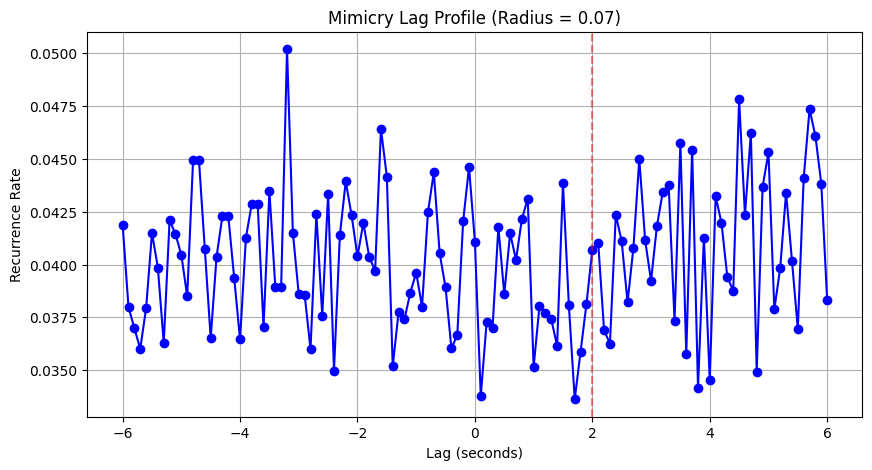

In [5]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_corrca.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_corrca.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(lags, rr_profile, 'b-o')
plt.axvline(2, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag (seconds)')
plt.ylabel('Recurrence Rate')
plt.title(f'Mimicry Lag Profile (Radius = {radius:.2f})')
plt.grid(True)
plt.show()


Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-0.69, 8.47]
Normalized ranges - P2: [-2.90, 6.36]
Radius: 1.0000, Current RR: 0.6054
Radius: 0.5050, Current RR: 0.3408
Radius: 0.2575, Current RR: 0.1713
Radius: 0.1338, Current RR: 0.0834
Radius: 0.0719, Current RR: 0.0487
Final radius: 0.0719
Max RR: 0.0643
Min RR: 0.0401


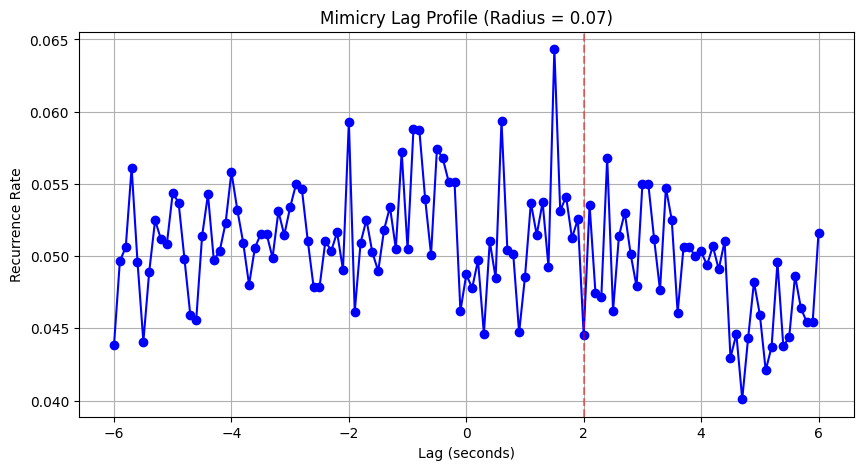

In [3]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_factors.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_factors.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(lags, rr_profile, 'b-o')
plt.axvline(2, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag (seconds)')
plt.ylabel('Recurrence Rate')
plt.title(f'Mimicry Lag Profile (Radius = {radius:.2f})')
plt.grid(True)
plt.show()


Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-0.69, 8.47]
Normalized ranges - P2: [-0.31, 13.99]
Radius: 1.0000, Current RR: 0.8118
Radius: 0.5050, Current RR: 0.6554
Radius: 0.2575, Current RR: 0.3016
Radius: 0.1338, Current RR: 0.1449
Radius: 0.0719, Current RR: 0.0876
Radius: 0.0409, Current RR: 0.0468
Final radius: 0.0409
Max RR: 0.0505
Min RR: 0.0417


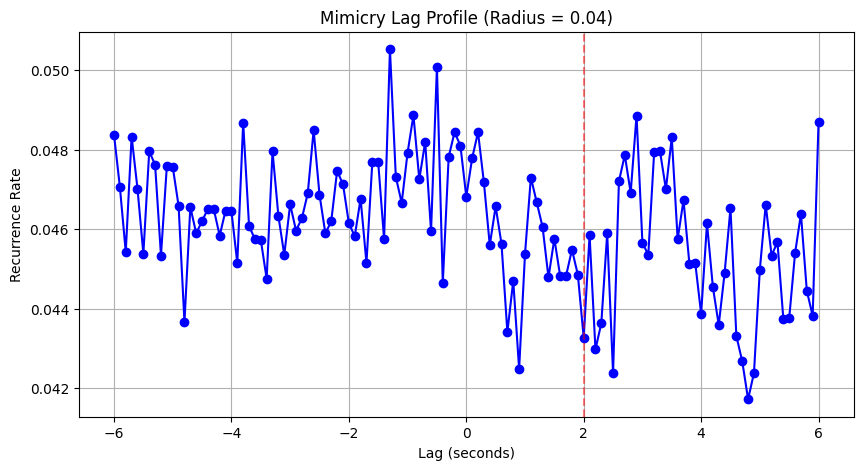

In [4]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_factors.csv'))
pil = pd.read_csv(os.path.join(files2, 'pp10_reschu_run_1_factors.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(lags, rr_profile, 'b-o')
plt.axvline(2, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag (seconds)')
plt.ylabel('Recurrence Rate')
plt.title(f'Mimicry Lag Profile (Radius = {radius:.2f})')
plt.grid(True)
plt.show()


c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


files of pairs in  do not have the same amount of datapoints - temporary fix has made them equal length


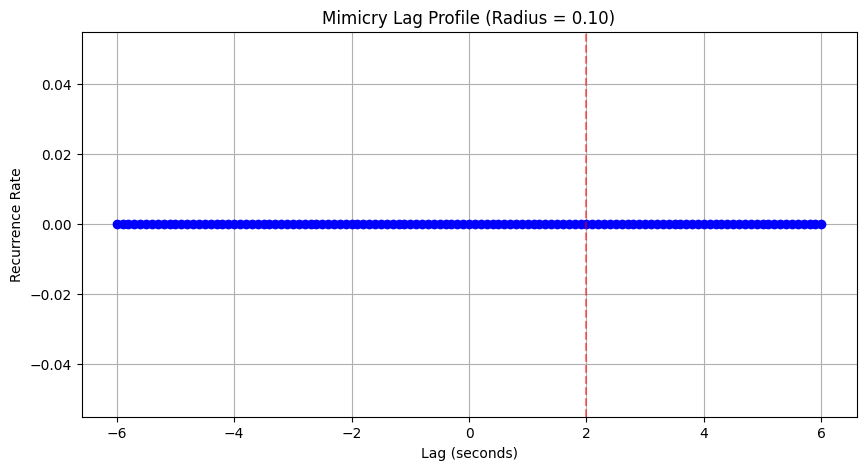

In [ ]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# synthetic example: y is x delayed by 0.5 s plus noise
 = 60
nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp19_discussion_phase_0_corrca.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp20_discussion_phase_0_corrca.csv")
nav, pil = fs.make_equal_length("", nav, pil)
x = nav.values
y = pil.values

# Example with synthetic data
import matplotlib.pyplot as plt

# Generate sample data (P2 lags P1 by 2 seconds)
fs = 60  # 60 Hz sampling rate
t = np.arange(0, 300)/fs  # 5 minutes of data
p1 = np.sin(2*np.pi*0.2*t)  # 0.2 Hz oscillation
p2 = np.roll(p1, int(2*fs))  # 2 second lag

# Run analysis
lags, rr_profile, radius = cm.crqa_lag_analysis(x, y, sampling_rate=fs)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(lags, rr_profile, 'b-o')
plt.axvline(2, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag (seconds)')
plt.ylabel('Recurrence Rate')
plt.title(f'Mimicry Lag Profile (Radius = {radius:.2f})')
plt.grid(True)
plt.show()


In [ ]:
60

3

In [ ]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns

nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp19_discussion_phase_0_corrca.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data\09_10\features\pp10_instructional_video_0_corrca.csv")
d = cm.crqa(f'2corma', nav['f2'].values[::10], pil['f2'].values[::10], radius=0.2, normalize=True, plot=True)


nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp19_discussion_phase_0_factors.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data\09_10\features\pp10_instructional_video_0_factors.csv")
d = cm.crqa(f'2facma', nav['f2'].values[::10], pil['f2'].values[::10], radius=0.2, normalize=True, plot=True)




Recurrence rate: 0.0689
Determinism: 0.3909
Laminarity: 0.6983
Average diagonal line length: 2.2943
Longest diagonal line length: 9
Recurrence rate: 0.2693
Determinism: 0.7335
Laminarity: 0.8501
Average diagonal line length: 3.5271
Longest diagonal line length: 38


In [1]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns

FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
columns = ['RR', 'DET', 'LAM', 'DIAavg', 'DIAlong', 'method', 'r', 'f']
df = pd.DataFrame(columns=columns)
radii = [0.1,0.2, 0.3,0.4, 0.5,0.6,0.7, 0.8]

little_location_place = 'old-data/19_20/correlations'

nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp19_discussion_phase_0_factors.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp20_discussion_phase_0_factors.csv")



for f in FACTORS:
    for r in radii:
        print(nav[f].values.shape, pil[f].values.shape)
        d = cm.crqa(f'CROSS_Norm_fac_rad{r}_{f}', nav[f].values, pil[f].values, radius=r, normalize=True, plot=False)
        d['method'] = 'fac'
        d['r'] = r
        d['f'] = f
        df_row = pd.DataFrame([d])
        df = pd.concat([df, df_row], ignore_index=True)
    


nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp19_discussion_phase_0_corrca.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\old-data\19_20\features\pp20_discussion_phase_0_corrca.csv")



for f in FACTORS[:3]:
    for r in radii:
        d = cm.crqa(f'CROSS_Norm_cor_rad{r}_{f}', nav[f].values, pil[f].values, radius=r, normalize=True, plot=False)
        d['method'] = 'cor'
        d['r'] = r
        d['f'] = f
        df_row = pd.DataFrame([d])
        df = pd.concat([df, df_row], ignore_index=True)

df.to_csv(f'{little_location_place}/crqa_norm_separate.csv')

c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


(8999,) (9001,)


C:\Users\Erik\AppData\Local\Temp\ipykernel_13604\2613758662.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], ignore_index=True)


(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)
(8999,) (9001,)


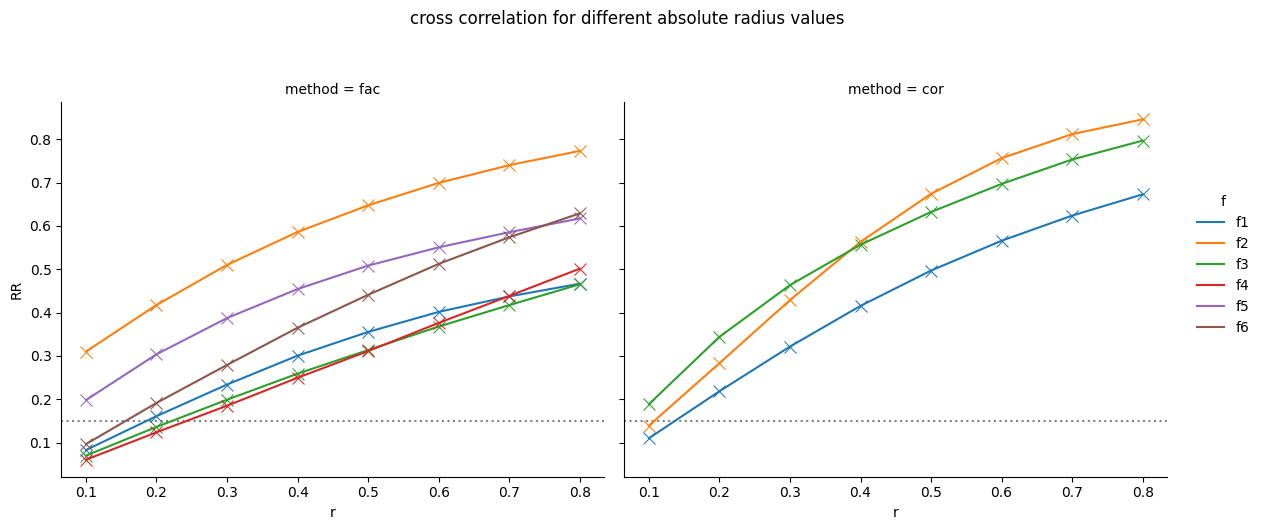

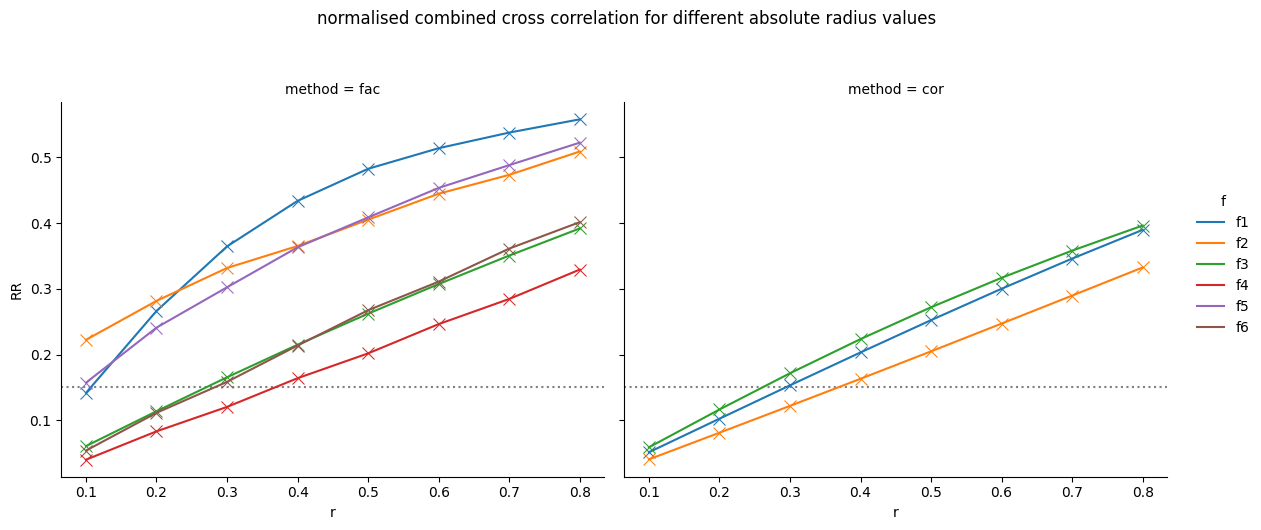

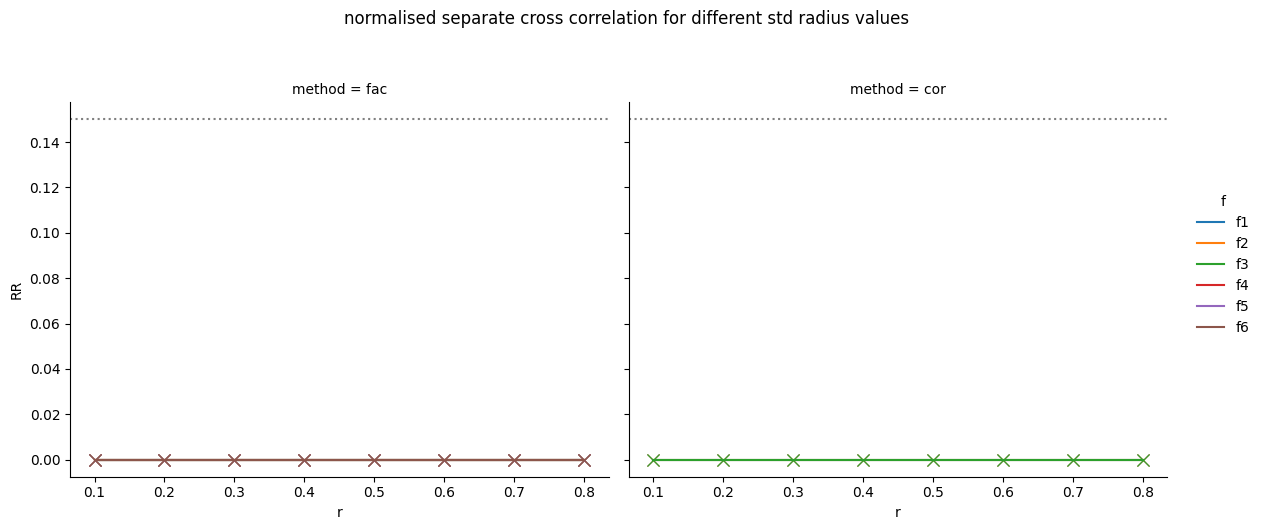

In [3]:
df = pd.read_csv(f'{little_location_place}/crqa.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.15, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('cross correlation for different absolute radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

df = pd.read_csv(f'{little_location_place}/crqa_norm_combined.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.15, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('normalised combined cross correlation for different absolute radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

df = pd.read_csv(f'{little_location_place}/crqa_norm_separate.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.15, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('normalised separate cross correlation for different std radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()


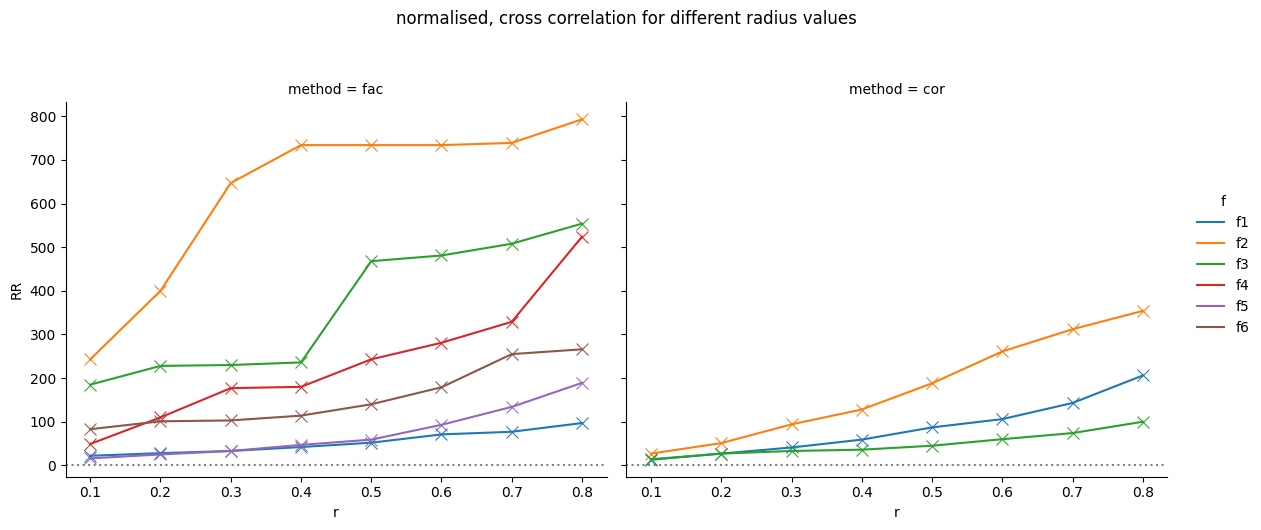

In [ ]:
df = pd.read_csv(f'{little_location_place}/SD_r_norm_separate.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.3, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('normalised, cross correlation for different radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

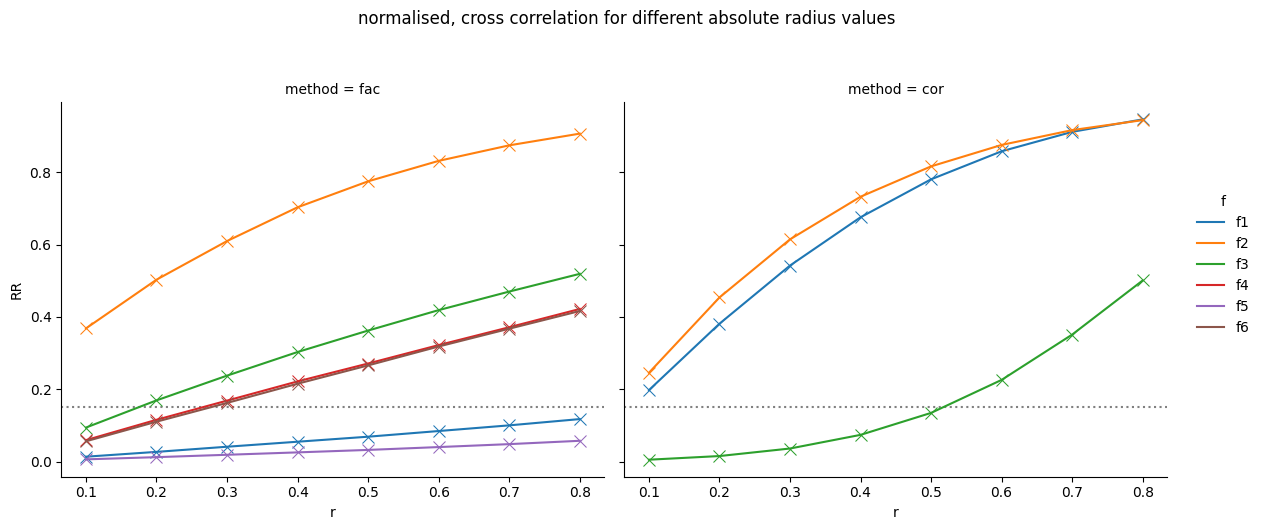

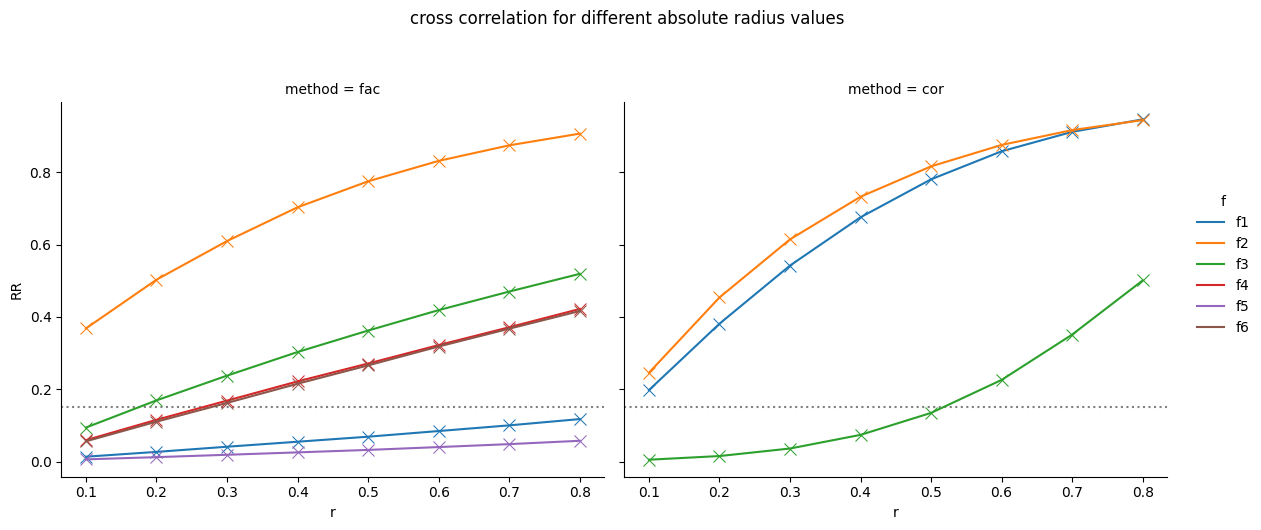

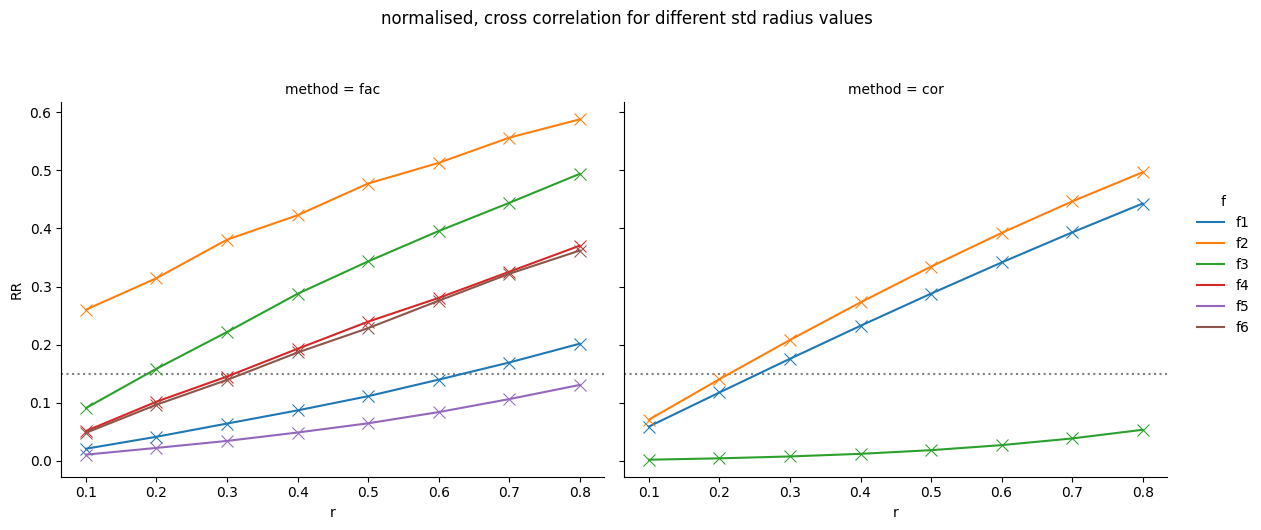

In [4]:
df = pd.read_csv(f'{little_location_place}/SD_r_norm_separate.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.15, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('normalised, cross correlation for different absolute radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

df = pd.read_csv(f'{little_location_place}/SD_r_norm_combined.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.15, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('cross correlation for different absolute radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

df = pd.read_csv(f'{little_location_place}/SD_r.csv')
g = sns.relplot(
    data=df,
    x='r',
    y='RR',
    hue='f',
    col='method',
    kind='line',
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    for line in ax.lines:
        line.set_marker('x')
        line.set_markersize(8)
        line.set_markeredgecolor(line.get_color())  # Match marker edge to line color
        line.set_markerfacecolor(line.get_color()) # Match marker face to line color
    ax.axhline(y=0.15, color='gray', linestyle=':', linewidth=1.5, zorder=0)

g.fig.suptitle('normalised, cross correlation for different std radius values', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()


In [44]:
normalised = pd.read_csv('results_normalised.csv')
weirdalised = pd.read_csv('results.csv')
normalised['norm'] = 'True'
weirdalised['norm'] = 'False'

df1 = pd.concat([normalised, weirdalised], ignore_index=True)

normalised = pd.read_csv('CROSS_normalised_results.csv')
weirdalised = pd.read_csv('CROSS_results.csv')
normalised['norm'] = 'True'
weirdalised['norm'] = 'False'

df2 = pd.concat([normalised, weirdalised], ignore_index=True)

normalised = pd.read_csv('CROSS_N2_results.csv')
weirdalised = pd.read_csv('cross_normalised.csv')
normalised['norm'] = 'False'
weirdalised['norm'] = 'True'

df3 = pd.concat([normalised, weirdalised], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'results_normalised.csv'

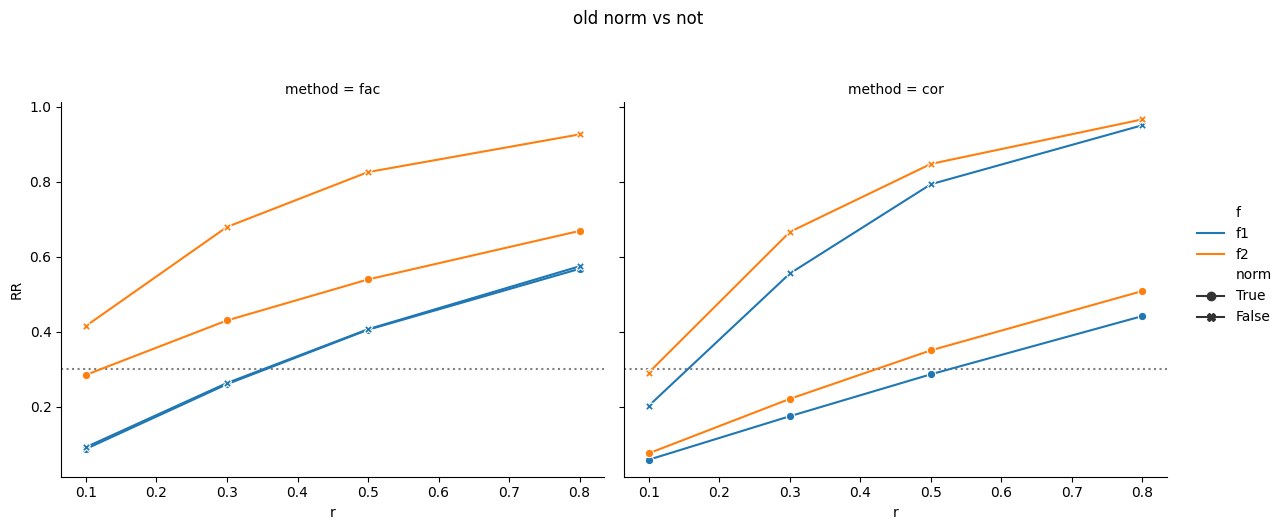

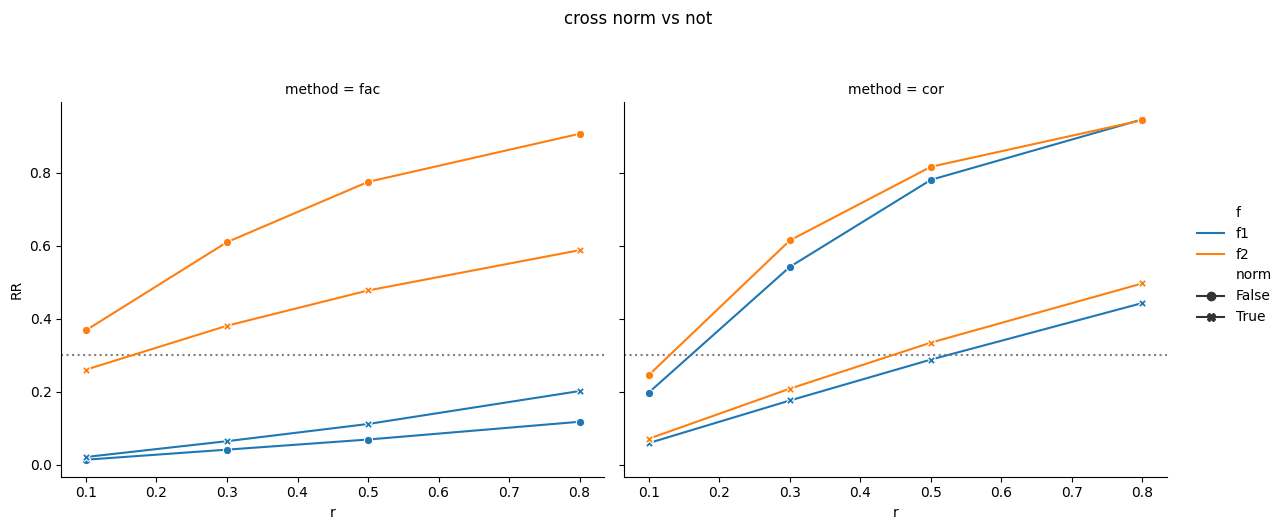

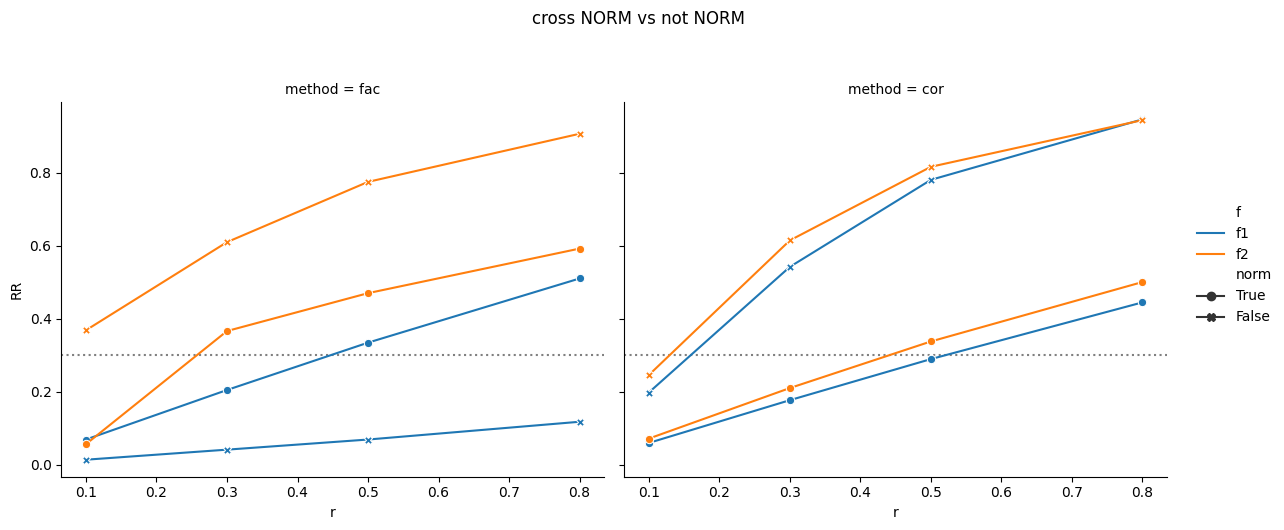

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(
    data=df1,
    x='r',
    y='RR',
    hue='f',
    style='norm',
    col='method',  # Split into subplots by 'normalised'
    kind='line',
    markers=True,
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    ax.axhline(
        y=0.3,
        color='gray',
        linestyle=':',
        linewidth=1.5,
        zorder=0  # Place behind the data lines
    )

g.fig.suptitle('old norm vs not', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

g = sns.relplot(
    data=df3,
    x='r',
    y='RR',
    hue='f',
    style='norm',
    col='method',  # Split into subplots by 'normalised'
    kind='line',
    markers=True,
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    ax.axhline(
        y=0.3,
        color='gray',
        linestyle=':',
        linewidth=1.5,
        zorder=0  # Place behind the data lines
    )

g.fig.suptitle('cross norm vs not', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()


g = sns.relplot(
    data=df2,
    x='r',
    y='RR',
    hue='f',
    style='norm',
    col='method',  # Split into subplots by 'normalised'
    kind='line',
    markers=True,
    dashes=False,
    facet_kws={'sharey': True, 'sharex': True},
    height=5,
    aspect=1.2
)

# Add horizontal line to all subplots
for ax in g.axes.flat:
    ax.axhline(
        y=0.3,
        color='gray',
        linestyle=':',
        linewidth=1.5,
        zorder=0  # Place behind the data lines
    )

g.fig.suptitle('cross NORM vs not NORM', y=1.05)
g.set_axis_labels('r', 'RR')
g.tight_layout()
plt.show()

In [14]:
df = pd.read_csv('results_normalised.csv')
df

,Unnamed: 0,RR,DET,LAM,DIAavg,DIAlong,method,r,f
0,0,0.087739,0.469013,0.683234,2.499171,32,fac,0.1,f1
1,1,0.260199,0.776476,0.877118,3.790098,176,fac,0.3,f1
2,2,0.405295,0.882030,0.934904,5.482863,426,fac,0.5,f1
3,3,0.567596,0.938790,0.965123,8.550396,2392,fac,0.8,f1
4,4,0.285003,0.915956,0.949123,9.201752,240,fac,0.1,f2
5,5,0.430035,0.936664,0.965622,9.801583,721,fac,0.3,f2
6,6,0.539242,0.953167,0.975380,11.194617,809,fac,0.5,f2
7,7,0.668623,0.972731,0.985431,14.669100,1167,fac,0.8,f2
8,8,0.058961,0.401234,0.592622,2.354718,14,cor,0.1,f1
9,9,0.174836,0.760753,0.863211,3.328368,59,cor,0.3,f1


In [ ]:

# nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp07_discussion_phase_0_factors.csv")
# pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp08_discussion_phase_0_factors.csv")



# for f in factors:
#     cm.crqa(f, nav[f].values, pil[f].values) 


# nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp07_discussion_phase_0_factors.csv")
# pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp08_discussion_phase_0_factors.csv")

# cm.crqa3(nav.iloc[1:].values, pil.iloc[1:].values)


# nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp07_discussion_phase_0_factors.csv")
# pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp08_discussion_phase_0_factors.csv")

# cm.mimicry(nav.iloc[1:].values, pil.iloc[1:].values)

In [ ]:
import pandas as pd
import util.correlation_measure as cm
nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp07_discussion_phase_0_factors.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp08_discussion_phase_0_factors.csv")
nav = nav.drop(columns=["frame"])
pil = pil.drop(columns=["frame"])
nav = cm.binarize_components(nav.values)
pil = cm.binarize_components(pil.values)

cm.crqa2("bin_factors",nav, pil)

nav = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp07_discussion_phase_0_corrca.csv")
pil = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\07_08\selection\pp08_discussion_phase_0_corrca.csv")
nav = nav.drop(columns=["frame"])
pil = pil.drop(columns=["frame"])
nav = cm.binarize_components(nav.values)
pil = cm.binarize_components(pil.values)

cm.crqa2("bin_corrca",nav, pil)

Recurrence rate: 0.3497
Determinism: 0.7576
Laminarity: 0.3193
Average diagonal line length: 3.0239
Longest diagonal line length: 353
Recurrence rate: 0.5056
Determinism: 0.5643
Laminarity: 0.7805
Average diagonal line length: 72.5376
Longest diagonal line length: 1028


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PHASES = ["05_06", "07_08", "09_10", "11_12", "13_14"]
for p in PHASES:
    df = pd.read_csv(f"C:\\Users\\Erik\\Documents\\facial-expression-synchrony\\data-out\\{p}\\{p}_corrca_weights.csv")
    w = df['w']
    isc = df['isc'].values  # Get values as a NumPy array

    isc = [np.abs(i) for i in isc]  # Take absolute values
    isc_sorted = sorted(isc, reverse=True)  # Sort in descending order (returns new list)

    tot = np.sum(isc)
    tmp = 0
    for index, i in enumerate(isc):
        tmp = tmp + i
        if tmp/tot > 0.75:
            print(index)
            break

    plt.plot(isc_sorted, label=p)

plt.legend()
plt.xlabel('Index')
plt.ylabel('ISC Value (Absolute)')
plt.title('Reverse Sorted Absolute ISC Values')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

PHASES = ["05_06", "07_08", "09_10", "11_12", "13_14"]
for p in PHASES:    
    df = pd.read_csv(f"C:\\Users\\Erik\\Documents\\facial-expression-synchrony\\data-out\\{p}\\{p}_corrca_weights.csv")
    isc = np.abs(df['isc'].values)  # Take absolute values and convert to NumPy array
    isc_sorted = np.sort(isc)[::-1]  # Sort in descending order

    # Compute cumulative contribution (optional)
    cumulative_isc = np.cumsum(isc_sorted) / np.sum(isc_sorted)  # Normalized cumulative sum

    # Create scree plot
    plt.figure(figsize=(10, 6))

    # Plot individual ISC values (bars or line)
    plt.plot(isc_sorted, 'b-', linewidth=2, label='Absolute ISC')
    plt.scatter(range(len(isc_sorted)), isc_sorted, color='red', s=20)  # Optional: dots for each value

    # Optional: Add cumulative contribution (dashed line)
    plt.plot(cumulative_isc * max(isc_sorted), 'g--', linewidth=1, label='Cumulative (scaled)')

    # Customize plot
    plt.xlabel('Component Rank (Sorted Descending)', fontsize=12)
    plt.ylabel('Absolute ISC Weight', fontsize=12)
    plt.title('Scree Plot of ISC Weights', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [ ]:
# general corrca
data = {}
nav, pil = pair.split("_")
nav_df = pd.DataFrame()
pil_df = pd.DataFrame()

for pair in os.listdir(LOCATION):
    print(pair)
    filename = os.path.join(LOCATION, pair)
    for file in os.listdir(os.path.join(filename, "au")):
        if ".csv" in file: 
            df = pd.read_csv(os.path.join(filename, "au", file))
            if ".csv" in file and nav in file:
                nav_df = pd.concat([nav_df, df])
            if ".csv" in file and pil in file:
                pil_df = pd.concat([pil_df, df])
nav_df, pil_df = fs.make_equal_length(pair, nav_df, pil_df)
w = fs.corrCA_weights(nav_df, pil_df) #output = pair/pair_corrca_weights.csv
w.to_csv(r"data-out/general_corrca_weights.csv", index=False)


In [ ]:
import os
import pandas as pd
import util.feature_extraction as fe
import util.feature_selection as fs
# corrCA takes a df as input. This df should be all files for a pair. 
LOCATION = 'data-out'

pair = "05_06"
filename = os.path.join(LOCATION, pair)
data = {}
nav, pil = pair.split("_")
nav_df = pd.DataFrame()
pil_df = pd.DataFrame()
# add all phases to a single dataframe
for file in os.listdir(os.path.join(filename, "")):
    if ".csv" in file: 
        df = pd.read_csv(os.path.join(filename, "au", file))
        if ".csv" in file and nav in file:
            nav_df = pd.concat([nav_df, df])
        if ".csv" in file and pil in file:
            pil_df = pd.concat([pil_df, df])
nav_df, pil_df = fs.make_equal_length(pair, nav_df, pil_df)
w = fs.corrCA_weights(nav_df, pil_df) #output = pair/pair_corrca_weights.csv
w.to_csv(os.path.join(filename, f"{pair}_corrca_weights.csv"), index=False)

LOCATION = 'data-out'
PHASES = ['discussion_phase_0', 'discussion_phase_1', 'instructional_video_0']
loc = os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')
w = pd.read_csv(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv'))
for file in os.listdir(os.path.join(LOCATION, pair, "au")):
    if ".csv" in file: 
        filename = os.path.join(LOCATION, pair, "au", file)
        participant, _ = file.split("_", 1)
        df = pd.read_csv(filename)
        for name in PHASES:
            if name in file:
                corrca = fs.apply_corrCA_weights(df, w, 3)
                corrca.to_csv(os.path.join(LOCATION, pair, "features", f"{participant}_{name}_corrca.csv"), index=False)
                continue



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data-out\\05_06\\au'